<a href="https://colab.research.google.com/github/ranjitunb/Activity-Monitoring/blob/master/Core_Facies_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/sample_data/Train_Set.rar")
patoolib.extract_archive("/content/sample_data/Test_Set.rar")

     |████████████████████████████████| 81kB 6.2MB/s 
patool: Extracting /content/sample_data/Train_Set.rar ...
patool: running /usr/bin/unrar x -- /content/sample_data/Train_Set.rar
patool:     with cwd='./Unpack_lqi67rxi'
patool: ... /content/sample_data/Train_Set.rar extracted to `Train_Set'.
patool: Extracting /content/sample_data/Test_Set.rar ...
patool: running /usr/bin/unrar x -- /content/sample_data/Test_Set.rar
patool:     with cwd='./Unpack__9mj8mzd'
patool: ... /content/sample_data/Test_Set.rar extracted to `Test_Set'.


'Test_Set'

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/Train_Set'
valid_path = '/content/Test_Set'

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/content/Train_Set/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [ ]:
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

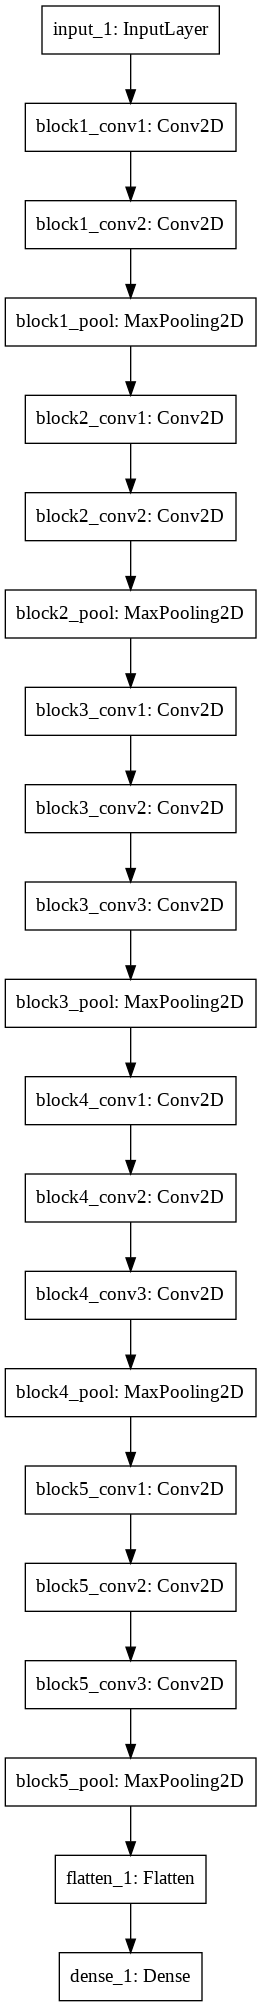

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/Train_Set',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/Test_Set',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                           shuffle=False)

Found 5342 images belonging to 4 classes.
Found 914 images belonging to 4 classes.


In [ ]:
# fit the model
from keras.callbacks import History
import math
history = History()
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50, callbacks = [history],
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
167/167 [==============================] - 74s 443ms/step - loss: 0.1140 - accuracy: 0.9564 - val_loss: 1.0367 - val_accuracy: 0.9026
Epoch 2/50
167/167 [==============================] - 70s 419ms/step - loss: 0.1257 - accuracy: 0.9496 - val_loss: 2.8509 - val_accuracy: 0.9190
Epoch 3/50
167/167 [==============================] - 70s 421ms/step - loss: 0.1267 - accuracy: 0.9517 - val_loss: 0.8851 - val_accuracy: 0.8818
Epoch 4/50
167/167 [==============================] - 71s 423ms/step - loss: 0.1064 - accuracy: 0.9592 - val_loss: 0.5842 - val_accuracy: 0.8917
Epoch 5/50
167/167 [==============================] - 69s 412ms/step - loss: 0.1075 - accuracy: 0.9599 - val_loss: 0.9443 - val_accuracy: 0.8982
Epoch 6/50
167/167 [==============================] - 69s 412ms/step - loss: 0.1239 - accuracy: 0.9534 - val_loss: 3.5156 - val_accuracy: 0.9136
Epoch 7/50
167/167 [==============================] - 69s 414ms/step - loss: 0.1060 - accuracy: 0.9569 - val_loss: 1.3216 - val_ac

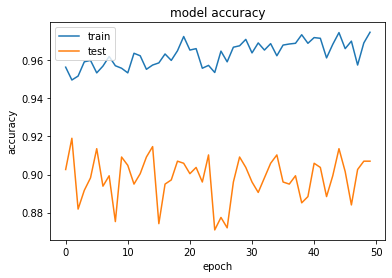

In [ ]:
# Summarizing history of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

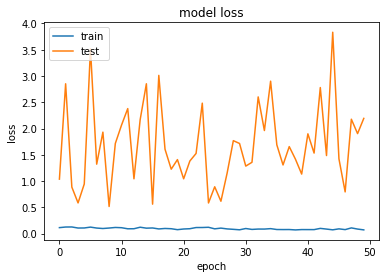

In [ ]:
# Summarizing history of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
batch_size = 32
num_of_test_samples = 914
predictions = model.predict_generator(test_set,  num_of_test_samples // batch_size+1)

y_pred = np.argmax(predictions, axis=1)

true_classes = test_set.classes

class_labels = list(test_set.class_indices.keys())

print(class_labels)

print(confusion_matrix(test_set.classes, y_pred))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

['Chalk', 'Sandstone', 'Shale', 'Siltstone']
[[384   0   0   0]
 [  0 316   0  34]
 [  0   6  56  13]
 [  0  26   6  73]]
              precision    recall  f1-score   support

       Chalk       1.00      1.00      1.00       384
   Sandstone       0.91      0.90      0.91       350
       Shale       0.90      0.75      0.82        75
   Siltstone       0.61      0.70      0.65       105

    accuracy                           0.91       914
   macro avg       0.85      0.84      0.84       914
weighted avg       0.91      0.91      0.91       914



In [ ]:
conf = confusion_matrix(test_set.classes, y_pred)
conf

array([[384,   0,   0,   0],
       [  0, 316,   0,  34],
       [  0,   6,  56,  13],
       [  0,  26,   6,  73]])

Text(51.0, 0.5, 'Actual')

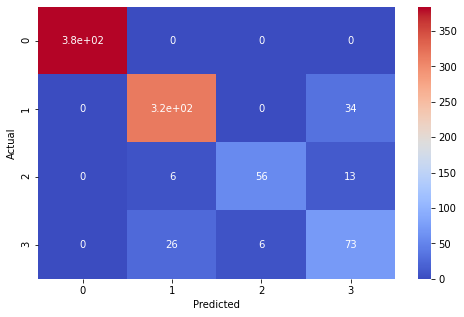

In [ ]:
import seaborn as sn
plt.figure(figsize = (8,5))
sn.heatmap(conf, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')